# Car classification challenge

In [119]:
#import necessary libraries
import torch
from torch import nn
import os
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import shutil
from pathlib import Path
import tqdm
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from pytorch_lightning import LightningModule, Trainer
import sklearn
from sklearn.metrics import confusion_matrix

### Transform the data into a format that can be used by the model

In [120]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the root directory where your dataset is located
root_directory = "DATA"

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust as needed
    transforms.ToTensor(),
])

# Use ImageFolder to load the dataset
car_dataset = ImageFolder(root=root_directory, transform=transform)

# Create a DataLoader for iterating through the dataset in batches
batch_size = 32  # Adjust as needed
data_loader = DataLoader(car_dataset, batch_size=batch_size, shuffle=True)

# Print the class labels assigned by ImageFolder
print("Class Labels:", car_dataset.classes)


Class Labels: ['Golf', 'bmw serie 1', 'chevrolet spark', 'chevroulet aveo', 'clio', 'duster', 'hyundai i10', 'hyundai tucson', 'logan', 'megane', 'mercedes class a', 'nemo citroen', 'octavia', 'picanto', 'polo', 'sandero', 'seat ibiza', 'symbol', 'toyota corolla', 'volkswagen tiguan']


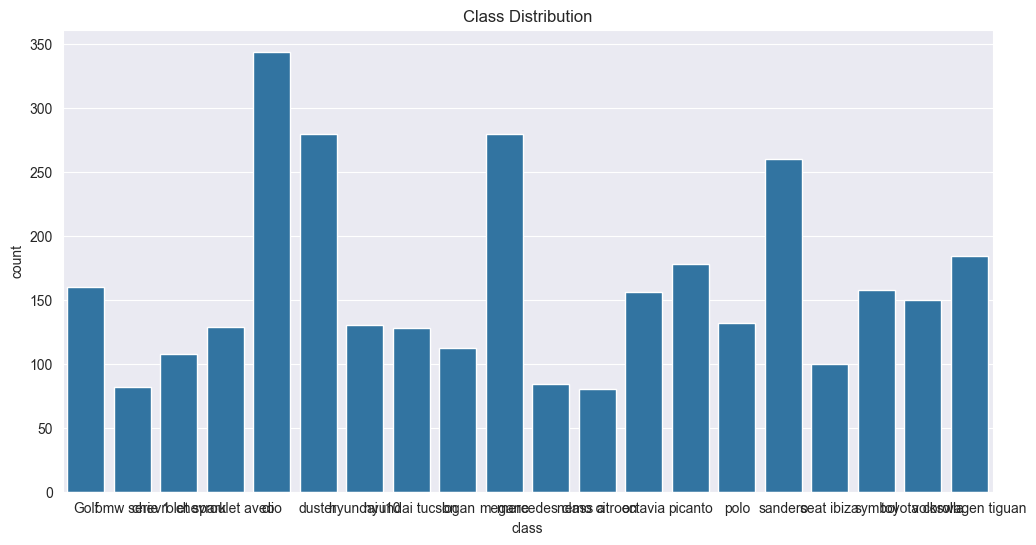

In [121]:
# check the distribution of the dataset classes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with the class labels and the number of images in each class
class_distribution = pd.DataFrame({
    "class": car_dataset.classes,
    "count": [0] * len(car_dataset.classes)
})

# Count the number of images in each class
for _, label in car_dataset:
    class_distribution.loc[label, "count"] += 1

# Plot the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=class_distribution, x="class", y="count")
plt.title("Class Distribution")
plt.show()


In [122]:
# split the dataset into train and test keeping the class labels and the number of images in each class
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(car_dataset, test_size=0.2, random_state=42, stratify=car_dataset.targets)


In [123]:
len(train_data), len(test_data)


(2588, 647)

In [124]:
image, label = train_data[0]
image.shape, label

(torch.Size([3, 224, 224]), 5)

In [125]:
# look at the label names
class_names = car_dataset.classes
class_names


['Golf',
 'bmw serie 1',
 'chevrolet spark',
 'chevroulet aveo',
 'clio',
 'duster',
 'hyundai i10',
 'hyundai tucson',
 'logan',
 'megane',
 'mercedes class a',
 'nemo citroen',
 'octavia',
 'picanto',
 'polo',
 'sandero',
 'seat ibiza',
 'symbol',
 'toyota corolla',
 'volkswagen tiguan']

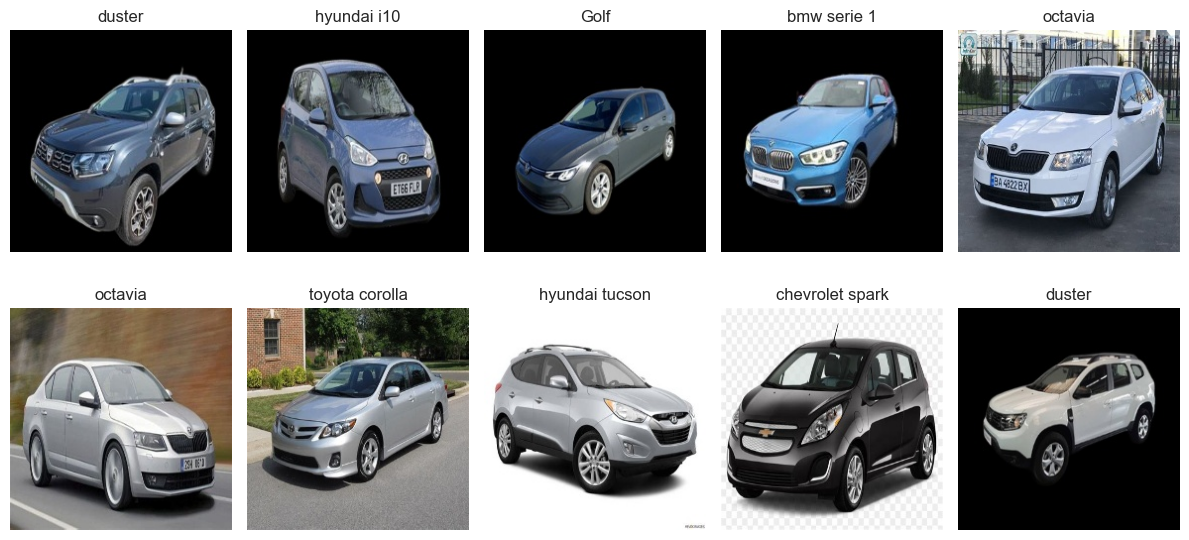

In [126]:
# plot the first 10 images in the dataset
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image, label = train_data[i]
    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.set_title(class_names[label])
    ax.axis('off')
plt.tight_layout()
plt.show()


### Create a Test and Training DataLoader

In [127]:
# prepare a dataloader for training and testing
#Turn datasets into iterables
BATCH_SIZE = 32
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)


In [128]:
# check output of the dataloader
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
test_features, test_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")


Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


In [129]:
# check out what we´ve created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}....")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x1561b0950>, <torch.utils.data.dataloader.DataLoader object at 0x155543b10>)
Length of train_dataloader: 81 batches of 32....
Length of test_dataloader: 21 batches of 32...


### Define the device to use

In [130]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

## Define the model

In [131]:

import torch.nn.functional as F
import torch.nn as nn
dropout_rate = 0.5
# Define the model
class CarsCNN(nn.Module):
    def __init__(self):
        super(CarsCNN, self).__init__()
        # input shape: 3 * 224 * 224
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # shape after conv1: 6 * 220 * 220
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # shape after pool: 6 * 110 * 110
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # shape after conv2: 16 * 106 * 106
        self.fc1 = nn.Linear(in_features=44944, out_features=120)
        # shape after fc1: 120
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # shape after fc2: 84
        self.fc3 = nn.Linear(in_features=84, out_features=20)
        # shape after fc3: 20 with batch size 32
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        #batch normalization layer
        self.batch_norm1 = nn.BatchNorm2d(6)
        self.batch_norm2 = nn.BatchNorm2d(16)
        #explain batch normalization layer: https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338
    
    # Define the forward pass
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #batch normalization layer
        x = self.batch_norm1(x)
        x = self.pool(F.relu(self.conv2(x)))
        # batch normalization layer
        x = self.batch_norm2(x)
        x = x.view(-1, 16 * 53 * 53)
       # print(f"after view: {x.shape}")
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        x = self.fc3(x)
        x = self.dropout2(x)
       # print(f"after fc3: {x.shape}")
        x = F.log_softmax(x, dim=1)
       # print(f"after log_softmax: {x.shape}")
        return x
        


## Import helper functions

In [132]:
import requests
from pathlib import Path
# Download helper functions from learn pytorch repo if not already downloaded

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary  

helper_functions.py already exists, skipping download


In [133]:

# Create an instance of the model
torch.manual_seed(42)
input_shape = (3, 224, 224)
class_names = car_dataset.classes
model_3 = CarsCNN()
epochs = 15

In [134]:
# setup loss funtion/eval metrics/optimizer
# import helper_functions
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),lr=0.01)

## Training Loop

In [135]:
#define train loop function
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device:torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

    #Add a loop through the training batches
  for batch, (X,y) in enumerate(data_loader):
    #Put data on target device
    X,y = X.to(device), y.to(device)

    # 1. Forward pass (outputs the raw logits from the model)
    y_pred = model(X)
    y_pred_probs = y_pred.softmax(dim=1) # convert logits to probabilities


    # 2. Calculate loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss #accumulate train loss
    #train_acc += accuracy_fn(y_true=y,y_pred=y_pred_probs.argmax(dim=1, keepdim=True)) #go from probabilities -> prediction labels
    
     # Calculate accuracy using torch.nn.functional.accuracy
    # Calculate accuracy manually
    correct = (y_pred_probs.argmax(dim=1) == y).sum()
    
    
    train_acc += correct.item() / len(y)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. Optimizer step (update the model´s parameters once *per batch*)
    optimizer.step()

  # divide total train
  train_loss /= len(data_loader)
  
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")
  
  return train_acc




## Testing Loop

In [136]:

# define test loop function
def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device:torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0,0 
  # Put the model in eval mode
  model.eval()
  test_pred_list = []
  label_list_list = []
  
  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in test_dataloader:
      #Send the data to the target device
      X,y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate the loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction lables
      test_pred_list.append(test_pred.argmax(dim=1))
      label_list_list.append(y)  
      
      
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test_acc: {test_acc:.2f}%\n")  
    
        
    return test_acc, test_loss


## Train and test the model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


#train and test model including early stopping
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n------")
  train_step(model=model_3,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_3,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device)







Epoch: 0
------
Train loss: 2.95245 | Train acc: 7.37%
Test loss: 2.87466 | Test_acc: 17.35%

Epoch: 1
------
Train loss: 2.79435 | Train acc: 13.37%
Test loss: 2.67658 | Test_acc: 27.25%

Epoch: 2
------
Train loss: 2.61822 | Train acc: 18.44%
Test loss: 2.59010 | Test_acc: 23.09%

Epoch: 3
------
Train loss: 2.46583 | Train acc: 21.58%
Test loss: 2.33945 | Test_acc: 43.71%

Epoch: 4
------


In [ ]:
# save the model
torch.save(model_3.state_dict(), "car_classification_model.pth")
